In [22]:
# Install required packages
!pip install aif360
!pip install scikit-learn
!pip install seaborn

In [23]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

In [24]:
# Load COMPAS dataset
dataset_orig = CompasDataset()

# Convert to pandas DataFrame for exploration
df = dataset_orig.convert_to_dataframe()[0]
df.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,...,c_charge_desc=Viol Injunct Domestic Violence,c_charge_desc=Viol Injunction Protect Dom Vi,c_charge_desc=Viol Pretrial Release Dom Viol,c_charge_desc=Viol Prot Injunc Repeat Viol,c_charge_desc=Violation License Restrictions,c_charge_desc=Violation Of Boater Safety Id,c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc=Voyeurism,c_charge_desc=arrest case no charge,two_year_recid
1,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,24.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,41.0,1.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


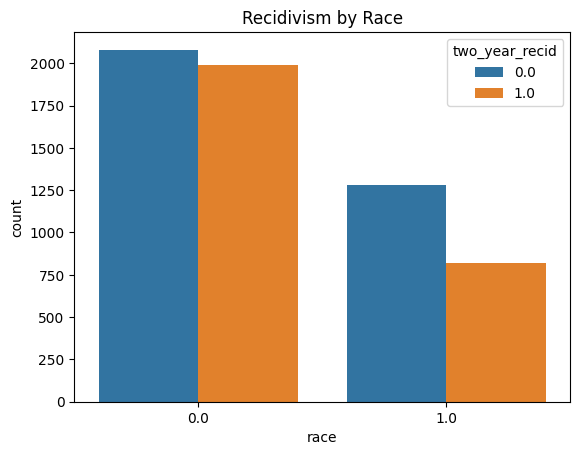

In [25]:
# Visualize class distribution by race
sns.countplot(data=df, x='race', hue='two_year_recid')
plt.title('Recidivism by Race')
plt.show()

In [26]:
# Split into train/test
from aif360.datasets import StandardDataset
from sklearn.model_selection import train_test_split

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [27]:
# Convert to numpy arrays
X_train = StandardScaler().fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

X_test = StandardScaler().fit_transform(dataset_orig_test.features)
y_test = dataset_orig_test.labels.ravel()

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6790923824959482


In [28]:
# Convert predictions to AIF360 format
from aif360.datasets import BinaryLabelDataset

dataset_pred = dataset_orig_test.copy()
dataset_pred.labels = y_pred

# Bias metrics
metric_orig = BinaryLabelDatasetMetric(dataset_orig_test, privileged_groups=[{'race': 1}], unprivileged_groups=[{'race': 0}])
metric_pred = ClassificationMetric(dataset_orig_test, dataset_pred, privileged_groups=[{'race': 1}], unprivileged_groups=[{'race': 0}])

print("Disparate Impact:", metric_pred.disparate_impact())
print("Statistical Parity Difference:", metric_pred.statistical_parity_difference())
print("Equal Opportunity Difference:", metric_pred.equal_opportunity_difference())

Disparate Impact: 0.7795754001103753
Statistical Parity Difference: -0.16454713522087072
Equal Opportunity Difference: -0.10800961362627026


In [29]:
RW = Reweighing(unprivileged_groups=[{'race': 0}], privileged_groups=[{'race': 1}])
dataset_transf = RW.fit_transform(dataset_orig_train)

# Retrain model
X_train_rw = StandardScaler().fit_transform(dataset_transf.features)
y_train_rw = dataset_transf.labels.ravel()

model_rw = LogisticRegression()
model_rw.fit(X_train_rw, y_train_rw)

# Predict and audit
y_pred_rw = model_rw.predict(X_test)
dataset_pred_rw = dataset_orig_test.copy()
dataset_pred_rw.labels = y_pred_rw

metric_pred_rw = ClassificationMetric(dataset_orig_test, dataset_pred_rw, privileged_groups=[{'race': 1}], unprivileged_groups=[{'race': 0}])

print("Post-Mitigation Disparate Impact:", metric_pred_rw.disparate_impact())
print("Post-Mitigation Statistical Parity Difference:", metric_pred_rw.statistical_parity_difference())

Post-Mitigation Disparate Impact: 0.7795754001103753
Post-Mitigation Statistical Parity Difference: -0.16454713522087072
